# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear regression, and run linear regressions that attempt to answer a question that Kiva borrowers may have: *What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. 

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Create explanatory features of interest 

3. Check our assumptions 

4. Linear Regression

5. Model Validation


First, we will load the packages we need for this section, and our data. As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. We will use this dataframe now. **If you haven't already, please run through Notebook 1!**  

In [72]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [73]:
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [74]:
# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

In [75]:
# Read in data
# Edit path to match your own
data_path = '/Users/anthonymiyoro/Documents/code/kivaMachineLearning/data/'
df = pd.read_csv(data_path+'df_module_1.csv', low_memory=False)

## Remove Loan Amount Outliers

In the exploratory module we introduced the concept of outliers and showed why it might be important to remove outlier loan amounts. Outliers are not strictly defined, but here, we suggest that a reasonable definition of an outlier is an observation that falls outside 3 standard deviations from the mean. In laymans terms, this means that an outlier is on the very tail end of a distribution. For a more rigorous definition of a standard deviation, read here: ***

Our data is very skewed by several extreme loan amount outliers. Now that we are considering a linear regression model, we should revisit removing our loan_amount outliers completely since they will cause bias in our results.

First, we look at the distribution of loans with outliers included.

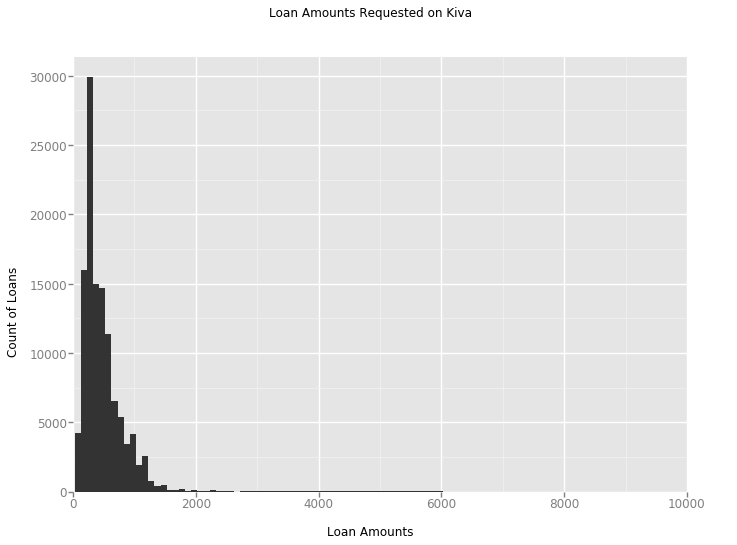

<ggplot: (324491184)>

In [76]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We first analyze the implications of removing outliers by creating a new dataframe without outliers. We call this df_removed_outliers. We can immediately see that the data is less skewed. This suggests we should remove outliers from our df dataframe permanently.

In [77]:
# Calculate Outliers
df_removed_outliers=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

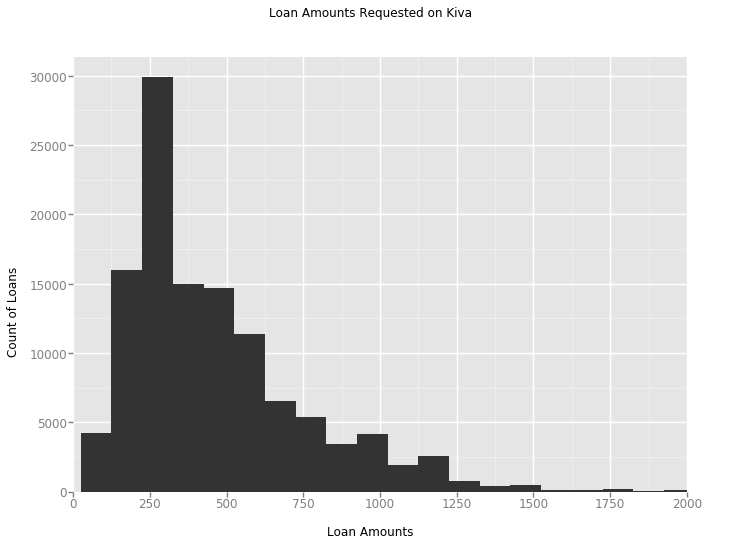

<ggplot: (322634560)>

In [78]:
ggplot(df_removed_outliers, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 2000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We should also examine what these outliers are to make sure they make sense excluding. We can see from the sample below that many of the biggest loans are for education grants. However, since so many of our loans are for $250, we conclude that the outliers are not representative of the typical Kiva borrower. But which loan should we exclude? Using the metric of standard deviation, it appears that many of the outliers as defined by those that lie outside the standard deviation are in fact for reasonable amounts. It is not clear we should simply exclude all of these loans.

In [79]:
outliers=df[~(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [80]:
outliers.head(20)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender
2446,2446,76,Cereals,0.0,False,"[{'first_name': 'Emmy', 'last_name': '', 'gend...",NaN,['en'],Emmy would be characterized by her neighbours ...,NaN,NaN,NaN,0,NaN,1290670,2514887,1,0,0,0,2825,Kenya,KE,town,1 38,point,Bomet,Emmy,156.0,[],2017-06-06,2017-05-07,Food,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",290000.0,KES,2017-04-29T07:00:00Z,2825,"[{'due_date': '2017-05-29T07:00:00Z', 'amount'...",...,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,NaN,NaN,to buy cereals.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-05-07 21:10:03,2017-06-06 21:10:03,NaN,2017-04-29 07:00:00,2017-04-29,2017,1,Female
2665,2665,724,Higher education costs,NaN,False,"[{'first_name': 'Emma', 'last_name': '', 'gend...",NaN,['en'],"Greetings from Nairobi, Kenya! <br /><br />Thi...",NaN,NaN,NaN,3375,2017-05-01,1283742,2505410,1,0,0,119,3375,Kenya,KE,town,-1.283333 36.816667,point,Nairobi,Emma,156.0,[],2017-05-30,2017-04-30,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}, ...",347200.0,KES,2017-04-23T07:00:00Z,3375,[],...,[],['Higher Education'],Usha Schmit,2047322.0,to pay for a course in human resource managment.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-04-30 02:20:02,2017-05-30 02:20:02,2017-05-01 14:38:23,2017-04-23 07:00:00,2017-04-23,2017,1,Female
7560,7560,15948,Farming,NaN,False,"[{'first_name': 'Ruth', 'last_name': '', 'gend...",NaN,['en'],"Ruth is a noble, hardworking, honest, and humb...",NaN,NaN,NaN,2975,2016-10-12,1144551,2295853,1,0,0,104,2975,Kenya,KE,town,1.016667 35,point,Kitale,Ruth,156.0,[],2016-10-13,2016-09-13,Agriculture,funded,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",300000.0,KES,2016-08-22T07:00:00Z,2975,[],...,[],NaN,JoEllen Wilkins,NaN,to buy good quality seeds and fertilizer for h...,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,770592

For now, let's be a little conservative. Instead of removing all observations that fall outside a standard deviation, let's simply restrict our analysis to loans below $6000. We can always come back and restrict it further using our outlier definition. We have commented out the code below, so we can come back and change what loans we exclude from our analysis.

In [81]:
# remove outliers from dataframe
#df=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [82]:
df=df[df['loan_amount']<6000]

In [83]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

In [84]:
df['loan_amount'].describe()

count    118190.000000
mean        480.851595
std         414.486963
min          25.000000
25%         250.000000
50%         375.000000
75%         600.000000
max        5975.000000
Name: loan_amount, dtype: float64

We import the dataset again below, this is just make clear the version we are using going foward. We can always change this import to df_module_1.csv if we decide excluding loans above $6000 was a mistake.

In [85]:
df = pd.read_csv(data_path+'df_module_2_w_outliers.csv', low_memory=False)

## Feature Engineering and Selection

When we try to think of features that will predict loan_amount, we are doing feature engineering. We may not end up using all the features we create, but it is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

We will also be selecting features along the way. Too few features results in low predictive power, and too many features may violate the assumption that there is no multicollinearity present (for more on multicollinearity, refer back to lecture slides!) Carefully choosing what features you think will be powerful enough to predict your outcome feature is difficult, and is subject to data availability and integrity problems. In short, it deserves your thoughtful consideration! 

*You should always make these preliminary checks in any feature you create to make sure it is what you expect!* 

   ### Demographics

Since we are interested in using the demographics of the Kiva borrowers as potential explanatory features, we will create, clean, and otherwise prepare these for linear regression. We are using a new method: str.contains. You may remember the method np.where from Notebook 1. 

In the cell below we use Numpy's  [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to create the widowed", "kids", and "elderly" features. 

We are using Numpy's filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

In [86]:
## Whether or not the borrower is widowed
#  Note the str.contains function

df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0)==True, 1, 0)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=0) ==True,1,0)

## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)

We create the features above because we believe age may drive the loan amount requested. However, all these new features face a data scarcity problem. The words are only contained in a handful of descriptions. 'Kids' is probably our most useful field since it is contained in about 24,571 loan descriptions. 

Data scarcity reduces the utility of the new field as an explanatory feature because if most observations of the feature is missing, it will not be a good discriminator in predicting loans. To understand this, think about if we are trying to predict nationality using accent. There are 20 nationalities present, but everyone has the same accent. Accent will not be useful anymore in getting us closer to seperating nationalities, we should instead rely on other features. 

This has still been a useful process, which is why we have included it in this notebook. Many steps in feature development involve creating features that will not ultimately be used. It is through creative exploration that we will eventually pinpoint our winning features. In fact, this has given us the idea to more systematically extract age.

In [87]:
df['widowed'].value_counts()
df['kids'].value_counts()
df['elderly'].value_counts()

0    115613
1      2577
Name: widowed, dtype: int64

1    99090
0    19100
Name: kids, dtype: int64

0    112715
1      5475
Name: elderly, dtype: int64

You can see in the boxplots below that none of these features differ much in the distribution of loan amount. That is another strong hint not to include them as features in our final model. Any good explanatory variable will cause variance in the explanatory variable.

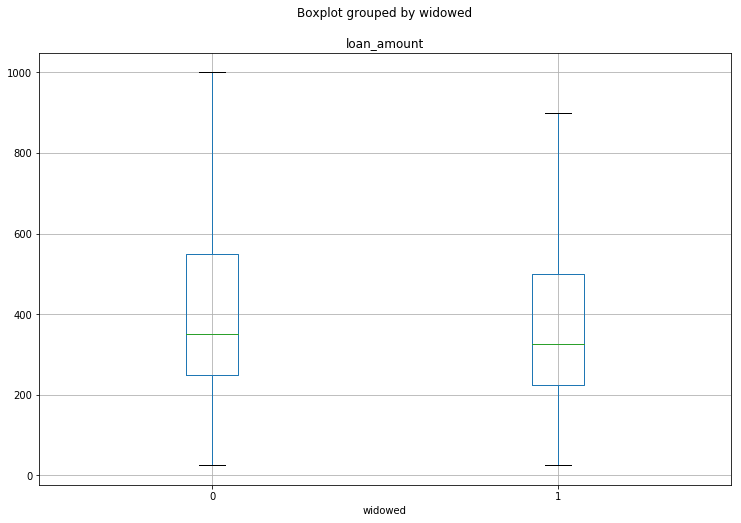

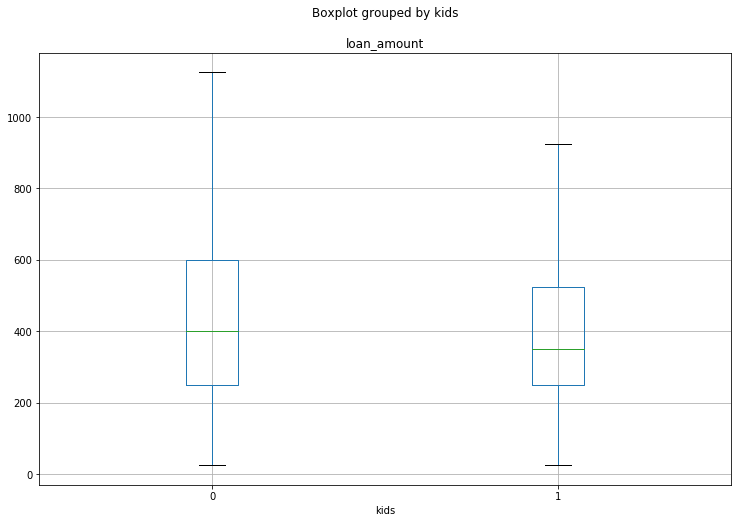

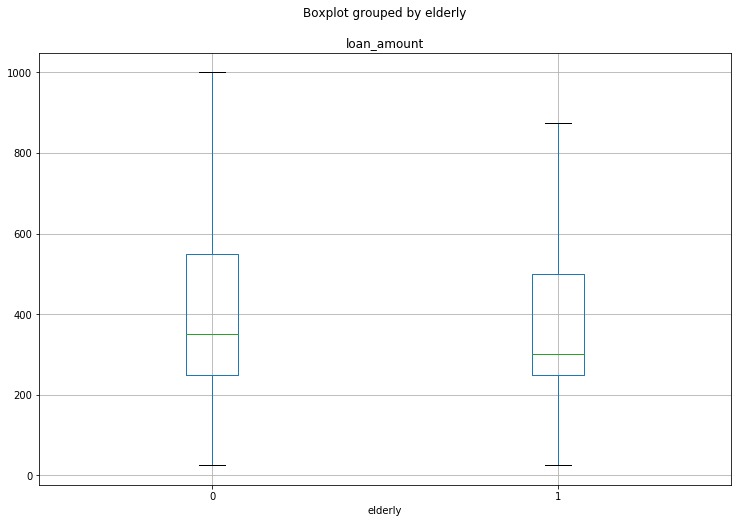

In [88]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='widowed', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='kids', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='elderly', showfliers=False, figsize=(12,8))

Our work with string matching has given us the idea to extract age. In the cells below, we parse out the **age** of the user by doing the following:

1. Importing a CSV mapping of age strings that appear in the Kiva description field (e.g. "2 years") to the integer counterparts (e.g. 2). 
2. We then define a function to check for each of these string values within the `description.texts.en` field of our main dataframe. If a match is found, we append that string value to a new list, "age", which we create at the start of the funtion. If no match is found, we append a blank string. When the function has completed, we have a list the same length of our main dataframe, with the corresponding age string value for each observation (e.g. "2 years" or " " if there is no age value available)
    1. We use functions from the [regular expression package](https://docs.python.org/2/library/re.html) to perform the string searches within the `description.texts.en`. Specifically, we use `re.compile` and  `re.findall` functions to first compile all possible age strings of interest, and then find all instances of the corresponding string.
3. We then create a new column in our main dataframe, "age", which is simply the list we created in step 2.
4. Finally, we perform a left join of our main dataframe with the CSV mapping, to map the string versions of age with their integer counterparts.



In [89]:
age_tag = pd.read_csv(data_path+'age.csv')

In [90]:
age_tag.head(2)

,age,age_int
0,1 years,1
1,2 years,2


In [91]:
## Age of borrower

# define a function that performs a loop that parses out all words, 
#  finds age match and creates new field

def text_search(tag):
    #creates empty lists that are then added to in loop
    age=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        age.append(word_1)
                    else:
                        age.append('')
        except:
            print('error')
            
    return(age)

In [92]:
## call the function we define above on the 'age' column of the age_tag dataframe we imported
age= text_search(age_tag['age'])

## create a new column 'age' in our main dataframe corresponding to the list generated from the text_search function
df['age']=pd.DataFrame(age)

In [93]:
df['age'].head(2)

0    44 years
1    42 years
Name: age, dtype: object

In [94]:
df=df.merge(age_tag, how='left', left_on='age', right_on='age')

We check out two new fields age and age_int by taking a slice of the dataframe.

In [95]:
df.sample(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,widowed,kids,elderly,age,age_int
98136,98194,98194,44902,Agriculture,NaN,False,"[{'first_name': 'Ainea', 'last_name': '', 'gen...",NaN,['en'],Ainea is 51 years old and is often referred to...,NaN,NaN,NaN,1425,2015-05-30,875280,1799909,1,0,0,45,1425,Kenya,KE,town,1 38,point,Matete,Ainea's Group,202.0,[],2015-05-30,2015-04-30,Agriculture,funded,"[{'name': '#Sustainable Ag'}, {'name': '#Eco-f...",133110.0,KES,2015-03-30T07:00:00Z,1425,...,NaN,NaN,NaN,NaN,14,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.364948,1.126878,NaN,0.123017,NaN,1592689,1,0.123017,9546,One Acre Fund,1.0,NaN,29.1,2.5,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2011-09-20T04:50:02Z,active,8133425,http://www.oneacrefund.org/,2015-04-30 17:20:09,2015-05-30 17:20:08,2015-05-30 12:22:59,2015-03-30 07:00:00,2015-03-30,2015,1,Male,0,1,1,44 years,44.0
113717,113843,113843,121931,Clothing Sales,NaN,False,"[{'first_name': 'Victor', 'last_name': '', 'ge...",NaN,['en'],Victor is a 30-year-old married man who sells ...,NaN,NaN,NaN,525,2010-05-04,192199,522058,1,0,0,18,525,Kenya,KE,town,1 38,point,Nairobi East,Victor,142.0,[],NaN,2010-04-10,Clothing,funded,[],40000.0,KES,2010-04-07T07:00:00Z,525,...,NaN,NaN,NaN,NaN,1,54.8,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.024923,0.619151,NaN,0.000000,NaN,2081410,1,0.000000,5945,Faulu Kenya,41.0,NaN,NaN,0.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2009-07-19T04:30:05Z,closed,2892775,http://www.faulukenya.com/,2010-04-10 14:20:03,NaN,2010-05-04 15:37:57,2010-04-07 07:00:00,2010-04-07,2010,1,Male,0,0,0,54 years,54.0


Below, we plot age against loan amount to get a sense of the strength of the relationship.

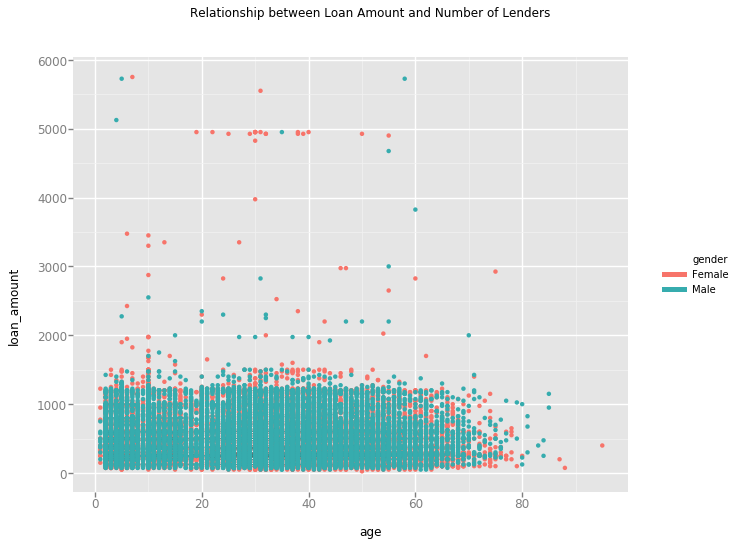

<ggplot: (276519800)>

In [96]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'age_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

From the chart above, we can see that while we have learnt something about the age distribution it is unfortunately not particularly powerful at predicting loan mount. We decide to try one more thing and bucket age to see if it strengthens the relationship.

In [97]:
mybins =range(0, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
df['age_bucket'].value_counts()

(30, 40]    12421
(0, 10]     12329
(20, 30]     9529
(40, 50]     8487
(10, 20]     6262
(50, 60]     4765
(60, 70]     1587
(70, 80]      234
Name: age_bucket, dtype: int64

Strange -- looks like there are a lot of 10 year olds borrowers! This doesn't make sense, so let's take a look at the data where age_int < 10 to investigate. 

In [98]:
df[df['age_int']< 10].head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,widowed,kids,elderly,age,age_int,age_bucket
15,15,15,96,Farm Supplies,0.0,False,"[{'first_name': 'George', 'last_name': '', 'ge...",NaN,['en'],George is a married man happily blessed with t...,NaN,NaN,NaN,0,NaN,1290533,2514679,1,0,0,0,1175,Kenya,KE,town,1 38,point,nyeri,George,386.0,[],2017-06-06,2017-05-07,Agriculture,fundraising,[{'name': '#Animals'}],120000.0,KES,2017-04-19T07:00:00Z,1175,...,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-07 19:10:09,2017-06-06 19:10:09,NaN,2017-04-19 07:00:00,2017-04-19,2017,1,Male,0,1,0,2 years,2.0,"(0, 10]"
80,80,80,631,Grocery Store,0.0,False,"[{'first_name': 'Grace', 'last_name': '', 'gen...",NaN,['en'],"Born in 1988, Grace is a mother of two childre...",NaN,NaN,NaN,0,NaN,1285419,2507787,1,0,0,0,400,Kenya,KE,town,1 38,point,Muranga,Grace,386.0,[],2017-05-31,2017-05-01,Food,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Vega...",40000.0,KES,2017-04-13T07:00:00Z,400,...,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-01 07:40:03,2017-05-31 07:40:03,NaN,2017-04-13 07:00:00,2017-04-13,2017,1,Female,0,1,0,8 years,8.0,"(0, 10]"
114,114,114,1710,Fruits & Vegetables,0.0,False,"[{'first_name': 'Joseph', 'last_name': '', 'ge...",NaN,['en'],Joseph is a 30-year-old man and is happily mar...,NaN,NaN,NaN,0,NaN,1275366,2494142,1,0,0,0,450,Kenya,KE,town,0.516667 36.866667,point,Narok,Joseph,386.0,[],2017-05-16,2017-04-16,Food,fundraising,"[{'name': '#Vegan'}, {'name': '#Parent'}, {'na...",45000.0,KES,2017-03-08T08:00:00Z,450,...,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-04-16 13:50:07,2017-05-16 13:50:07,NaN,2017-03-08 08:00:00,2017-03-08,2017,1,Male,0,1,0,1 years,1.0,"(0, 10]"
143,143,143,1794,Shoe Sales,0.0,False,"[{'first_name': 'Mary', 'last_name': '', 'gend...",NaN,['en'],"Born in 1979, Mary is a married lady and a mot...",NaN,NaN,NaN,0,NaN,1274033,2492469,1,0,0,0,800,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Mary,386.0,[],2017-

The data tells us that many people are not reporting their own age, but in fact are telling us about their young children. This reveals a big data integrity problem - the feature age_int is not what we thought it was. This raises the question of how many people reported their age in the first place. One way to address this is to conservatively only look at observations where the age is more than 20. We do this below by starting at bins at 20.

In [99]:
mybins =range(20, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
df['age_bucket'].value_counts()

(30, 40]    12421
(20, 30]     9529
(40, 50]     8487
(50, 60]     4765
(60, 70]     1587
(70, 80]      234
Name: age_bucket, dtype: int64

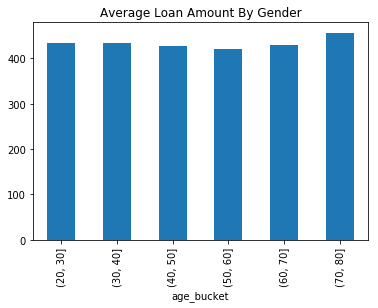

In [100]:
df[df['borrower_count'] == 1].groupby('age_bucket')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

Unfortunately, it did not improve the relationship. While 70-80 year olds appear to be requesting larger loans on avg it is very similar amounts for all other ages. But don't despair! Again, meeting dead ends in feature engineering is a perfectly normal part of developing a model. We included all these weaker feature explorations so you can understand that even experienced data scientists try a lot of things that are not successful. 

The best way to build a successful model is to iterate quickly and not get stuck when a feature doesn't work out.

We do have one demographic feature we will be retunring to from our initial exploratory analysis. We know that the appears to be a relationship between gender and loan_amount requested.

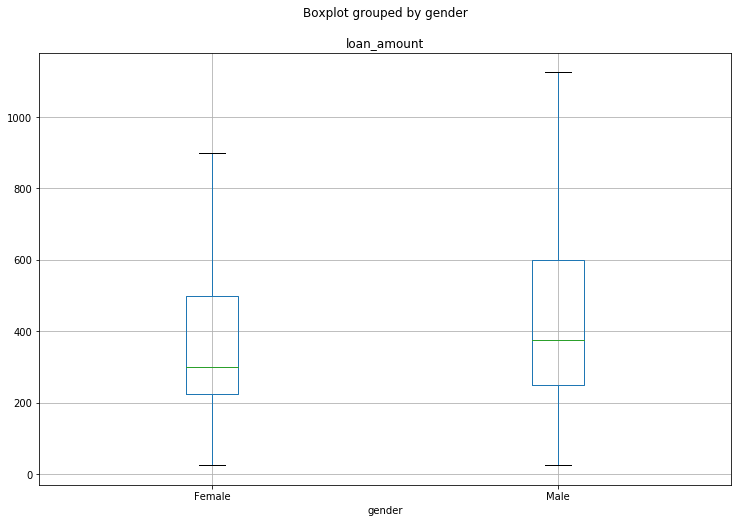

In [101]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='gender', showfliers=False, figsize=(12,8))

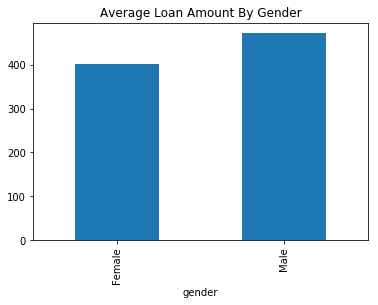

In [102]:
df[df['borrower_count'] == 1].groupby('gender')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

### Loan features

Next we create features related to the conditions surrounding each loan posting that we believe may drive loan amount.

We know from our exploratory analysis in the last lesson that sector and activity are both important drivers of loan amount. We will be including both of these in our linear regression.

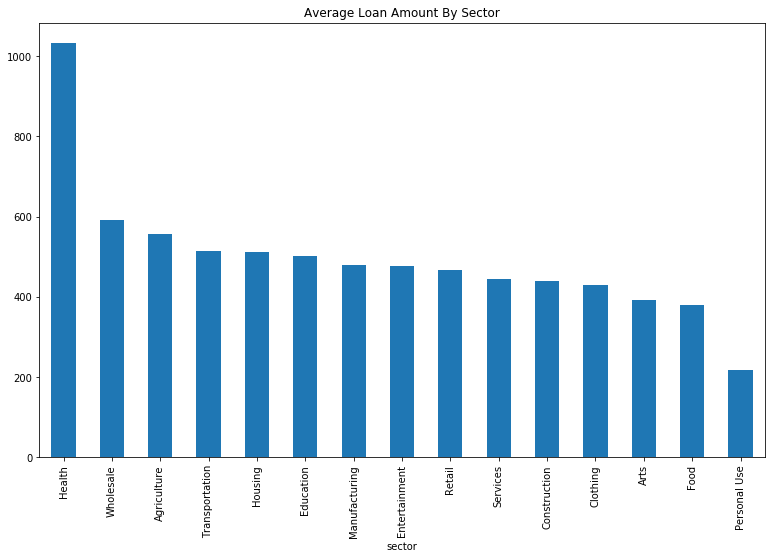

In [103]:
df.groupby('sector')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Sector", figsize=(13, 8))

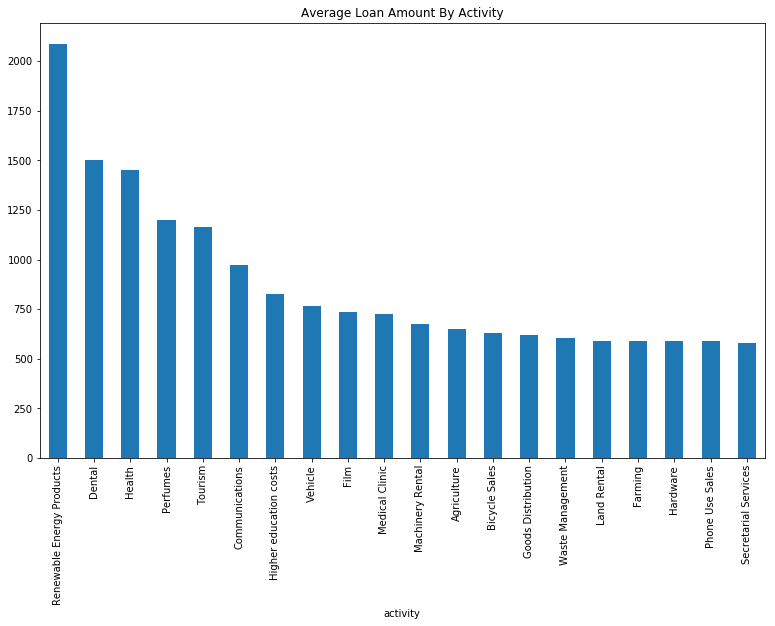

In [104]:
df.groupby('activity')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Activity", figsize=(13, 8))

In order to get information on time, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them. In this case, we want to find out how many days elapsed between two dates, so we subtract the earlier date from the later date and report the output in days. 

As we saw in Module 1, we already ensured our date features are converted to datetime format using the `to_datetime` function. However, in reading in our "df" csv file, Python forgot the Pandas format we assigned. Therefore we convert our created variables to datetime format again. We then create a day feature from each of the datetime differences we calculate.

In [105]:
## Ensuring datetime format
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])

## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days
df['posted_year']=df['posted_datetime'].dt.year
df['posted_month']=df['posted_datetime'].dt.month

In [106]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,widowed,kids,elderly,age,age_int,age_bucket,time_to_expire_datetime,days_to_expire,posted_month
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,...,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Female,0,1,0,44 years,44.0,"(40, 50]",30 days,30.0,5
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,...,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Male,0,1,0,42 years,42.0,"(40, 50]",30 days,30.0,5


We already saw in during our exploratory analysis in Notebook 1 that loan sizes seemed fairly stable by year. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

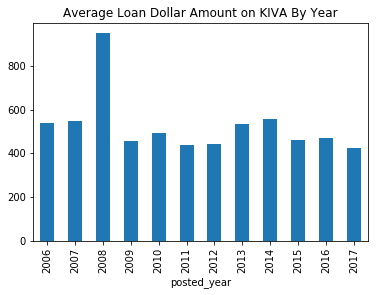

In [107]:
df.groupby('posted_year')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

It might be interesting to also look at loan size by month since end-of-year celebrations or the beginning of the school year in January may affect lending patterns. We can see below that the loan amount is on average higher in November, December and February. It is worth looking at using a box plot.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

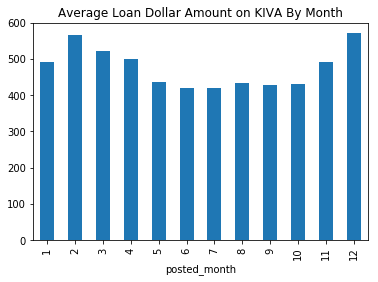

In [108]:
df.groupby('posted_month')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Month')
plt.xticks(rotation=90)

The boxplot confirms our suspicion this may be worth including as a feature as it shows variance in distribution between months.

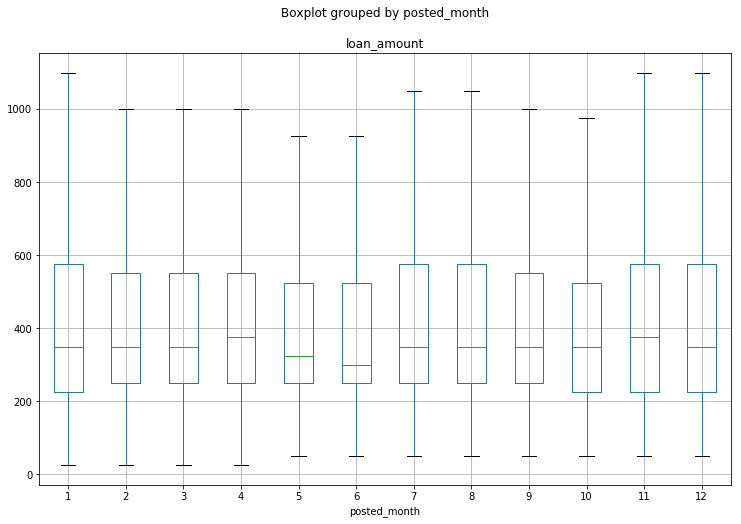

In [109]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='posted_month', showfliers=False, figsize=(12,8))

How do partners affect loan amount? Does a partner's profitability have anything to do with the loan amount issued.

In [110]:
df[df['partner_profitability']<0]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,widowed,kids,elderly,age,age_int,age_bucket,time_to_expire_datetime,days_to_expire,posted_month
2388,2388,2388,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,...,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-05-09 00:30:04,2017-06-08 00:30:03,NaN,2017-04-28 07:00:00,2017-04-28,2017,1,Female,0,1,0,,NaN,NaN,29 days 23:59:59,29.0,5
2389,2389,2389,4,Farming,0.0,False,"[{'first_name': 'Alice', 'last_name': '', 'gen...",NaN,['en'],Alice (the woman pictured above in her small s...,NaN,NaN,NaN,0,NaN,1291518,2515975,1,0,0,0,400,Kenya,KE,town,1 38,point,Nandi Hills,Alice,156.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,[{'name': '#Woman Owned Biz'}],40000.0,KES,2017-05-27T07:00:00Z,400,...,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-05-09 00:20:03,2017-06-08 00:20:03,NaN,2017-05-27 07:00:00,2017-05-27,2017,1,Female,0,0,0,,NaN,NaN,30 days 00:00:00,30.0,5
2390,2390,2390,6,Farming,25.0,False,"[{'first_name': 'Mary', 'last_name': '', 'gend...",NaN,['en'],"Wonderful Kiva community, meet Mary (pictured ...",NaN,NaN,NaN,125,NaN,1291516,2515972,1,0,0,5,150,Kenya,KE,town,1 38,point,Kerugoya,Mary,156.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",15000.0,KES,2017-04-27T07:00:00Z,150,...,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-05-09 00:10:03,2017-06-08 00:10:03,NaN,2017-04-27 07:00:00,2017-04-27,2017,1,Female,0,0,0,,NaN,NaN,30 days 00:00:00,30.0,5
2391,2391,2391,9,Cereals,0.0,False,"[{'first_name': 'Emily ', 'last_name': '', 'ge...",NaN,['en'],"Meet this enterprising woman, Emily. She resid...",NaN,NaN,NaN,0,NaN,1291486,2515930,1,0,0,0,500,Kenya,KE,town,1 3

Below we see that partner deliquency appears to have postive relationship with loan amount. This suggests that some partners may be requesting too high a loan amount, and are unable to pay it back.

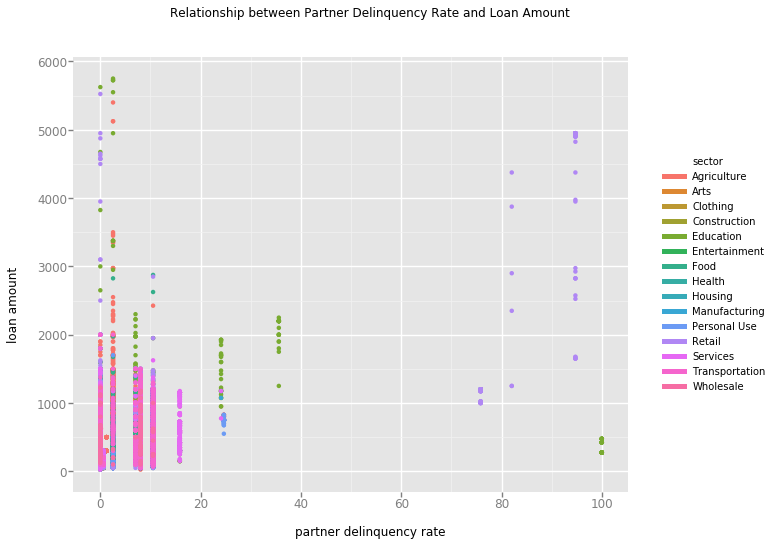

<ggplot: (334191396)>

In [111]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_delinquency_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Partner Delinquency Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

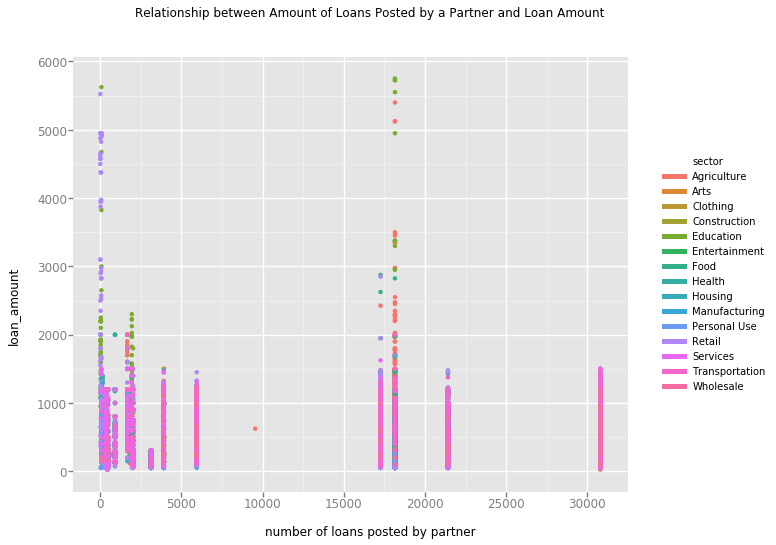

<ggplot: (349673834)>

In [112]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_posted', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Amount of Loans Posted by a Partner and Loan Amount") + xlab("number of loans posted by partner") + ylab("loan_amount")

### Tag Features

Next we create features related to miscellaneous relevant information included in the loan's tags. Specifically, it could be interesting to consider the following: 
1. Is the loan eco-friendly?
2. Does the loan relate to animals?  
3. Does the loan involve technology?

As with the demographic features above, we are using Numpy's [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to search for relevant tag-words

In [113]:
## Is the loan eco-friendly?
df['eco_friendly'] = np.where(df['tags'].str.contains("#Eco-friendly", na=0) ==True, 1, 0)

## Does the loan relate to animals?
df['animals'] = np.where(df['tags'].str.contains("#Animals", na=0) ==True, 1, 0)

## Does the loan involve technology?
df['technology'] = np.where(df['tags'].str.contains("#Technology", na=0) ==True, 1, 0)

In [114]:
df['eco_friendly'].value_counts()
df['animals'].value_counts()


0    108503
1      9687
Name: eco_friendly, dtype: int64

0    111262
1      6928
Name: animals, dtype: int64

What else could influence loan amount? Are there any features you would engineer for this problem. Try and think of three features that could predict loan amount requested. Show all the exploratory analysis you do to justify including it in the model (including charts).

## Feature 1

In [115]:
## Does loan amount influence repeat borrowing?
df['Repeat_Borrower'] = np.where(df['tags'].str.contains("#Repeat Borrower", na=0) ==True, 1, 0)

In [116]:
df['Repeat_Borrower'].value_counts()

0    104954
1     13236
Name: Repeat_Borrower, dtype: int64

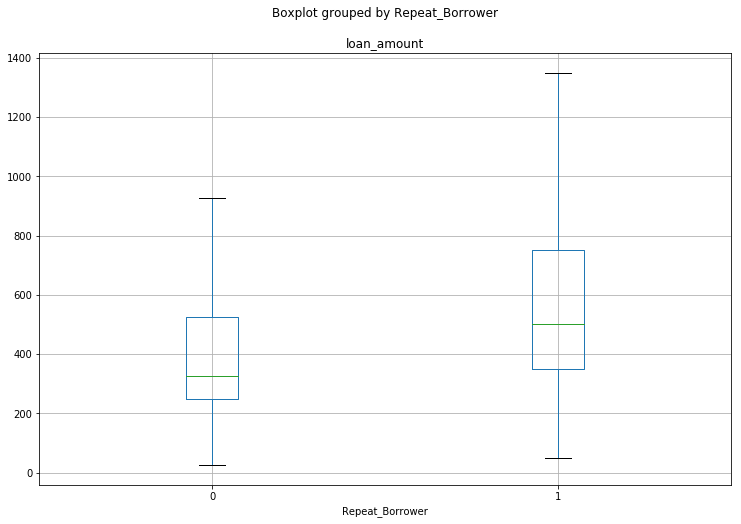

In [117]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='Repeat_Borrower', showfliers=False, figsize=(12,8))

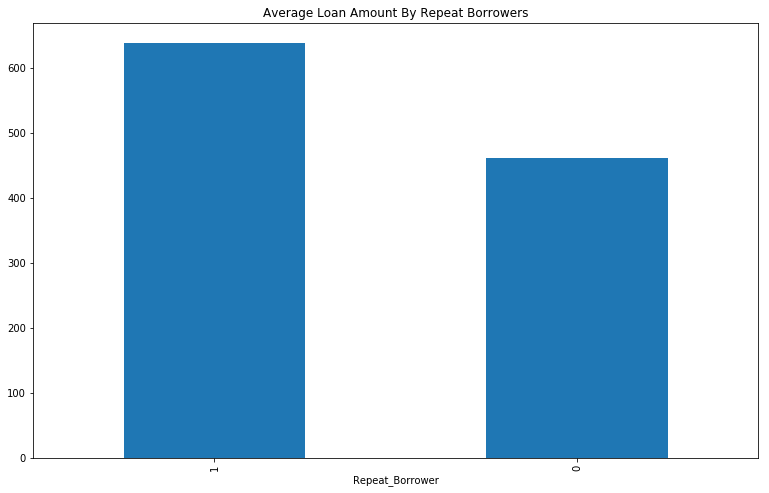

In [118]:
df.groupby('Repeat_Borrower')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Repeat Borrowers", figsize=(13, 8))

## Feature 2

In [119]:
## Does the loan involve Women?
df['woman_owned'] = np.where(df['tags'].str.contains("#Woman Owned Biz", na=0) ==True, 1, 0)

In [120]:
df['woman_owned'].value_counts()

0    95941
1    22249
Name: woman_owned, dtype: int64

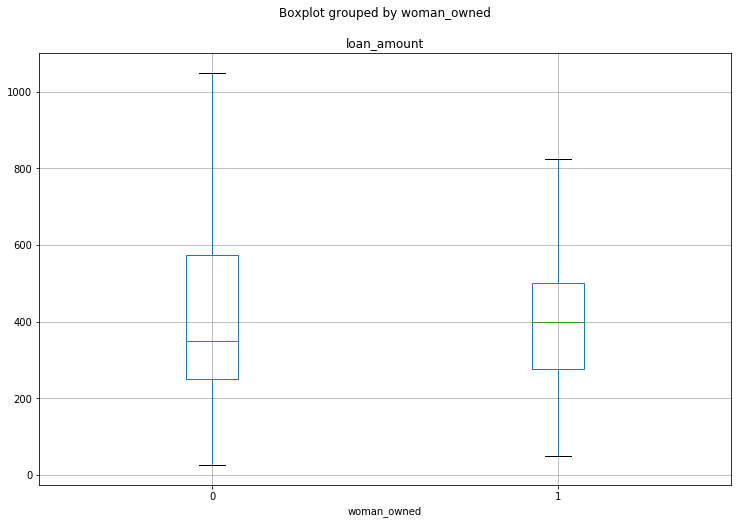

In [121]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='woman_owned', showfliers=False, figsize=(12,8))

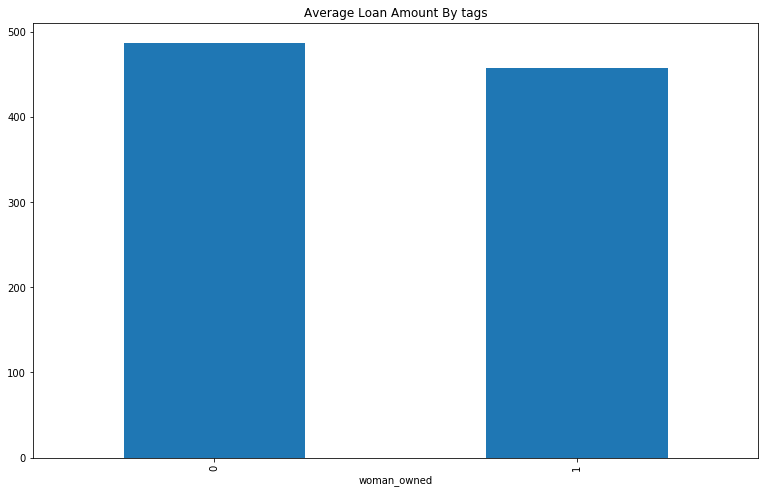

In [122]:
df.groupby('woman_owned')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By tags", figsize=(13, 8))

We can then have a pie chart representing the different values


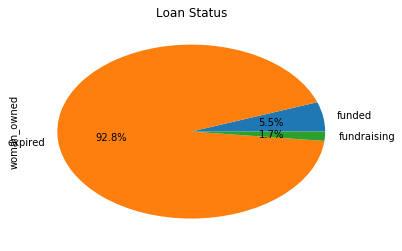

In [123]:
# status

print ("We can then have a pie chart representing the different values")

labels = 'funded', 'expired', 'fundraising'
df.groupby('status')['woman_owned'].sum().plot(kind='pie', title='Loan Status', labels=labels, autopct='%1.1f%%')

We can then have a pie chart representing the different values


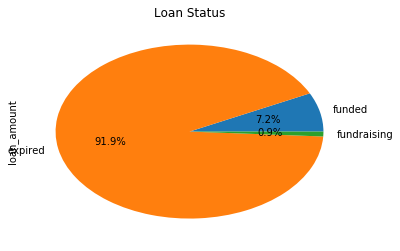

In [124]:
print ("We can then have a pie chart representing the different values")

labels = 'funded', 'expired', 'fundraising'
df.groupby('status')['loan_amount'].sum().plot(kind='pie', title='Loan Status', labels=labels, autopct='%1.1f%%')

## Feature 3

## Checking Assumptions

### Normality
In Module 3, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our dependent variable, loan_amounts.

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.

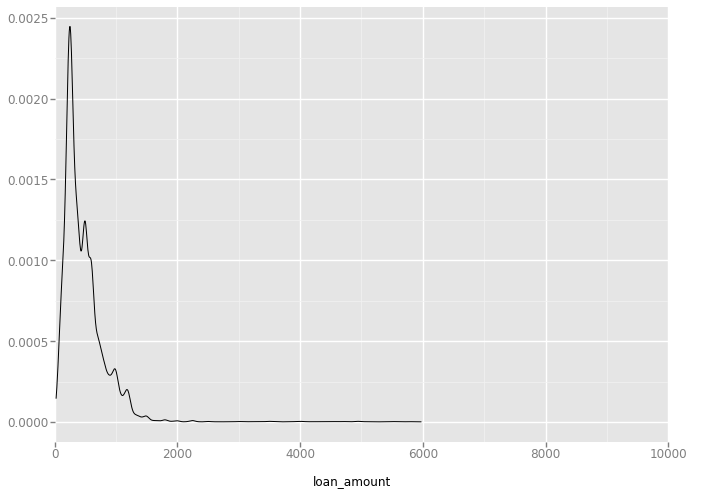

<ggplot: (-9223372036469443668)>

In [125]:
# Skew test
ggplot(df, aes(x='loan_amount')) + geom_density() + xlim(0,10000)

In [126]:
# Skew test results
print(stats.skew(df.loan_amount, axis=None))

5.284713044709114


This confirms our suspicion that the data is skewed to the left. However, the degree to which it is skewed is not troubling. +-5 is fairly reasonable. In the cell below we describe a way to address this if you face a dataset with more severely skewed data.

## Additional context on how to deal with skewed data:


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!

In [127]:
# correlation between loan amount and funded amount

np.corrcoef(df.loan_amount, df.funded_amount)

np.corrcoef(df.loan_amount, df.partner_loans_posted)

array([[ 1.        ,  0.94901885],
       [ 0.94901885,  1.        ]])

array([[ 1.        , -0.20095008],
       [-0.20095008,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [128]:
df_corr_tbl = df[['loan_amount','partner_loans_posted', 'posted_month', 'partner_delinquency_rate']]
df_corr_tbl.corr()

,loan_amount,partner_loans_posted,posted_month,partner_delinquency_rate
loan_amount,1.000000,-0.200950,-0.020123,0.013236
partner_loans_posted,-0.200950,1.000000,0.004218,0.315802
posted_month,-0.020123,0.004218,1.000000,0.008176
partner_delinquency_rate,0.013236,0.315802,0.008176,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. It appears we have no issues with collinearity.

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on outcome feature loan_amount. We encourage you to explore other outcome features!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [129]:
# Set training-test split %
split_pct = 0.80

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function. Let's try a simple example to start: 

In [130]:
model0 = sm.ols(formula="loan_amount ~ gender", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 31 Aug 2017   Prob (F-statistic):          4.18e-256
Time:                        19:37:25   Log-Likelihood:            -8.7946e+05
No. Observations:              118190   AIC:                         1.759e+06
Df Residuals:                  118188   BIC:                         1.759e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        451.7113      1.471    307.

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 424.30 + 87.10*male
    
Let's state the results. Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the loan amount increases by 110 dollars. This is consistent with our earlier explanatory analysis. How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. **But which ones?**

Before we move unto homework, remember to output your final dataframe so you don't have to rerun it.

In [131]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

## Homework

Choose three other features you think might influence loan amount. Interpret the results by writing a statement like the one below that we wrote to understand the relationship with gender:

"Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the predicted loan amount increases by 110 dollars." 


### Univariate Regression 1

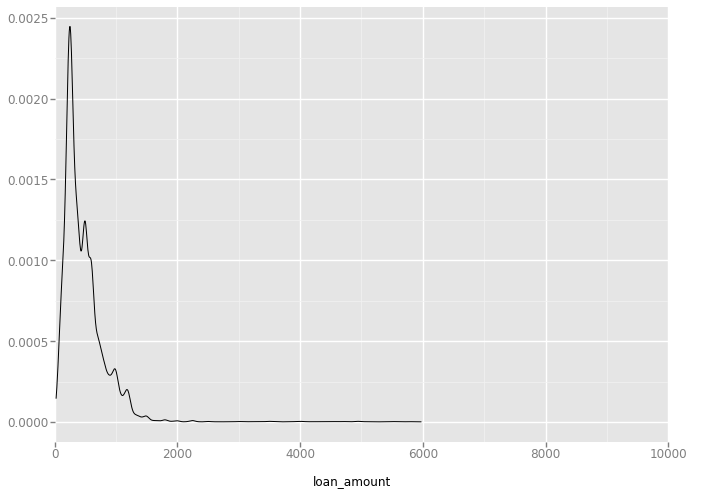

<ggplot: (-9223372036532547433)>

5.284713044709114
Skew result of +-5 is fine :)


In [132]:
# Skew test of loan amount
ggplot(df, aes(x='loan_amount')) + geom_density() + xlim(0,10000)

# Skew test results
print(stats.skew(df.loan_amount, axis=None))

print ('Skew result of +-5 is fine :)')

In [133]:
print ('Check for collinearity in the data')

# correlation between loan amount and repeat borrowing
np.corrcoef(df.loan_amount, df['Repeat_Borrower'])

print ('There is a low correlation between loan_amount and repeat borrowing')

Check for collinearity in the data


array([[ 1.        ,  0.13431533],
       [ 0.13431533,  1.        ]])

There is a low correlation between loan_amount and repeat borrowing


In [134]:
print ('We then create a correlation matrix to visualise all variables well be using')

df_corr_tbl = df[['loan_amount','partner_loans_posted', 'posted_month', 'partner_delinquency_rate', 'Repeat_Borrower', 'woman_owned']]
df_corr_tbl.corr()

print ('We can then begin regression!')


We then create a correlation matrix to visualise all variables well be using


,loan_amount,partner_loans_posted,posted_month,partner_delinquency_rate,Repeat_Borrower,woman_owned
loan_amount,1.000000,-0.200950,-0.020123,0.013236,0.134315,-0.027022
partner_loans_posted,-0.200950,1.000000,0.004218,0.315802,-0.086274,0.015610
posted_month,-0.020123,0.004218,1.000000,0.008176,-0.028437,0.043414
partner_delinquency_rate,0.013236,0.315802,0.008176,1.000000,0.118265,0.019257
Repeat_Borrower,0.134315,-0.086274,-0.028437,0.118265,1.000000,0.172984
woman_owned,-0.027022,0.015610,0.043414,0.019257,0.172984,1.000000


We can then begin regression!


In [135]:
# Set training-test split %
split_pct = 0.70

#  the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

# Create a training set on 70% of the data and use the rest as a test set
train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):] 

In [136]:
print ("We'll now run the regression on train_set")

model1 = sm.ols(formula="loan_amount ~ Repeat_Borrower", data=train_set).fit()
print(model1.summary())

We'll now run the regression on train_set
                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2171.
Date:                Thu, 31 Aug 2017   Prob (F-statistic):               0.00
Time:                        19:37:45   Log-Likelihood:            -8.7896e+05
No. Observations:              118190   AIC:                         1.758e+06
Df Residuals:                  118188   BIC:                         1.758e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------


In [137]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

### Univariate Regression 2

In [138]:
model2 = sm.ols(formula="loan_amount ~ woman_owned", data=train_set).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     86.36
Date:                Thu, 31 Aug 2017   Prob (F-statistic):           1.52e-20
Time:                        19:38:04   Log-Likelihood:            -8.8000e+05
No. Observations:              118190   AIC:                         1.760e+06
Df Residuals:                  118188   BIC:                         1.760e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     486.2452      1.338    363.499      

### Univariate Regression 3

Multivariate regression is where there are multiple explanatory variables. Below is a code template for you to start playing with a multivariate model. Interpret your results.

In [145]:
# model1 = sm.ols(formula="[replace with the name of your outcome feature] ~[replace with the name of your explantory variable 1]  +[replace with the name of your explantory variable 1] +[replace with the name of your explantory variable 1] +", data=train_set)
# model1_results = model1.fit()
# print(model1_results.summary())

model1 = sm.ols(formula="loan_amount ~ borrower_count + sector + kids + gender + widowed + posted_year +\
                days_to_expire + partner_profitability + eco_friendly + animals + elderly", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 31 Aug 2017   Prob (F-statistic):               0.00
Time:                        19:41:47   Log-Likelihood:            -6.5912e+05
No. Observations:               89730   AIC:                         1.318e+06
Df Residuals:                   89705   BIC:                         1.319e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               